In [1]:
# Baseline-Modelle V1

# Variante A Immer-PSP (höchste Erfolgsrate)
# Variante B Immer-PSP (niedrigste Kosten)
# Variante C Regelbasiertes Modell (nach Betrag)
#Vergleich Baseline-Modelleimport pandas as pd

import numpy as np
import pandas as pd

# Daten laden und unnötige Spalte entfernen
df = pd.read_excel("../data/raw/PSP_Jan_Feb_2019.xlsx")
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Transaktionskosten-Tabellen
costs_success = {'Moneycard': 5, 'Goldcard': 10, 'UK_Card': 3, 'Simplecard': 1}
costs_fail = {'Moneycard': 2, 'Goldcard': 5, 'UK_Card': 1, 'Simplecard': 0.5}

# Baseline Modell: Immer Goldcard (höchste Erfolgsrate)
df['baseline_A_PSP'] = 'Goldcard'
df['baseline_A_success'] = df.apply(lambda x: 1 if (x['success'] == 1 and x['PSP'] == 'Goldcard') else 0, axis=1)
df['baseline_A_cost'] = df['success'].apply(lambda s: costs_success['Goldcard'] if s == 1 else costs_fail['Goldcard'])

# Baseline Modell: Immer Simplecard (niedrigste Kosten)
df['baseline_B_PSP'] = 'Simplecard'
df['baseline_B_success'] = df.apply(lambda x: 1 if (x['success'] == 1 and x['PSP'] == 'Simplecard') else 0, axis=1)
df['baseline_B_cost'] = df['success'].apply(lambda s: costs_success['Simplecard'] if s == 1 else costs_fail['Simplecard'])

# Baseline Modell: Regelbasiert nach Betrag
def regelbasiert_psp(amount):
    if amount < 100:
        return 'Simplecard'
    elif amount < 300:
        return 'UK_Card'
    else:
        return 'Goldcard'

df['baseline_C_PSP'] = df['amount'].apply(regelbasiert_psp)
def get_cost(row, psp):
    return costs_success[psp] if row['success'] == 1 else costs_fail[psp]

df['baseline_C_cost'] = df.apply(lambda row: get_cost(row, row['baseline_C_PSP']), axis=1)
df['baseline_C_success'] = df.apply(lambda x: 1 if (x['success'] == 1 and x['PSP'] == x['baseline_C_PSP']) else 0, axis=1)

# Auswertung
def auswertung(success_col, cost_col):
    erfolgsrate = df[success_col].mean()
    durchschnittskosten = df[cost_col].mean()
    return erfolgsrate, durchschnittskosten

erfolg_A, kosten_A = auswertung('baseline_A_success', 'baseline_A_cost')
erfolg_B, kosten_B = auswertung('baseline_B_success', 'baseline_B_cost')
erfolg_C, kosten_C = auswertung('baseline_C_success', 'baseline_C_cost')

print(f"Variante A (immer Goldcard): Erfolgsrate = {erfolg_A:.3f}, Ø Kosten = {kosten_A:.2f} €")
print(f"Variante B (immer Simplecard): Erfolgsrate = {erfolg_B:.3f}, Ø Kosten = {kosten_B:.2f} €")
print(f"Variante C (regelbasiert): Erfolgsrate = {erfolg_C:.3f}, Ø Kosten = {kosten_C:.2f} €")


Variante A (immer Goldcard): Erfolgsrate = 0.026, Ø Kosten = 6.01 €
Variante B (immer Simplecard): Erfolgsrate = 0.039, Ø Kosten = 0.60 €
Variante C (regelbasiert): Erfolgsrate = 0.081, Ø Kosten = 1.99 €


In [1]:
# Baseline-Modelle V2
import pandas as pd

# Datensatz laden
df = pd.read_excel("../data/raw/PSP_Jan_Feb_2019.xlsx")
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Erfolgsraten je PSP
erfolgsraten = df.groupby('PSP')['success'].mean()
print("Erfolgsraten je PSP:")
print(erfolgsraten)
print()

# Kostenstruktur
kosten_erfolg = {'Moneycard': 5, 'Goldcard': 10, 'UK_Card': 3, 'Simplecard': 1}
kosten_fail = {'Moneycard': 2, 'Goldcard': 5, 'UK_Card': 1, 'Simplecard': 0.5}

# Baseline A: Immer denselben PSP (Was-wäre-wenn)
print("Baseline A: Immer nur einen PSP wählen")
for psp in erfolgsraten.index:
    avg_success = erfolgsraten[psp]
    avg_cost = avg_success * kosten_erfolg[psp] + (1 - avg_success) * kosten_fail[psp]
    print(f"PSP: {psp:10} | Erfolgsrate: {avg_success:.3f} | Ø Kosten: {avg_cost:.2f} €")
print()

# Baseline B: Regelbasiert nach Betrag
def regelbasiert_psp(amount):
    if amount < 100:
        return 'Simplecard'
    elif amount < 300:
        return 'UK_Card'
    else:
        return 'Goldcard'

df['baseline_PSP'] = df['amount'].apply(regelbasiert_psp)
df['baseline_success'] = df['baseline_PSP'].map(erfolgsraten)
df['baseline_cost'] = df['baseline_PSP'].apply(lambda psp: kosten_erfolg[psp]) * df['baseline_success'] + \
                      df['baseline_PSP'].apply(lambda psp: kosten_fail[psp]) * (1 - df['baseline_success'])

regel_success = df['baseline_success'].mean()
regel_cost = df['baseline_cost'].mean()
print(f"Baseline B (regelbasiert): Erfolgsrate: {regel_success:.3f} | Ø Kosten: {regel_cost:.2f} €")


Erfolgsraten je PSP:
PSP
Goldcard      0.406172
Moneycard     0.218754
Simplecard    0.158123
UK_Card       0.194338
Name: success, dtype: float64

Baseline A: Immer nur einen PSP wählen
PSP: Goldcard   | Erfolgsrate: 0.406 | Ø Kosten: 7.03 €
PSP: Moneycard  | Erfolgsrate: 0.219 | Ø Kosten: 2.66 €
PSP: Simplecard | Erfolgsrate: 0.158 | Ø Kosten: 0.58 €
PSP: UK_Card    | Erfolgsrate: 0.194 | Ø Kosten: 1.39 €

Baseline B (regelbasiert): Erfolgsrate: 0.223 | Ø Kosten: 2.17 €


In [2]:
#Datenaufbereitung für das ML-Modell inkl. Speicherung als CSV

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# 1. Datensatz laden
df = pd.read_excel("../data/raw/PSP_Jan_Feb_2019.xlsx")
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Neue Features zu Zahlungsversuchen berechnen
df['minute'] = pd.to_datetime(df['tmsp']).dt.floor('T')
df['attempt_group'] = df.groupby(['minute', 'country', 'amount']).ngroup()
df['attempt_number'] = df.groupby('attempt_group').cumcount() + 1
df['total_attempts'] = df.groupby('attempt_group')['amount'].transform('count')

# 3. Auswahl der relevanten Features und Zielvariable
features = ['amount', '3D_secured', 'card', 'country', 'PSP',
            'attempt_number', 'total_attempts']
X = df[features]
y = df['success']

# 4. Kategorische Variablen in numerische umwandeln (One-Hot-Encoding)
X_encoded = pd.get_dummies(X, columns=['card', 'country', 'PSP'], drop_first=True)

# 5. Aufteilen in Trainings- und Testdaten (z.B. 80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Ordner für verarbeitete Daten erstellen, falls nicht vorhanden
os.makedirs("../data/processed/", exist_ok=True)

# 7. Speichern als CSV
X_train.to_csv("../data/processed/X_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

# 8. Überblick und Kontrolle
print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test :", y_test.shape)
print("Dateien wurden erfolgreich im Ordner '../data/processed/' gespeichert.")
print("Beispiel für neue Features (erste Zeilen):")
print(X_train[['attempt_number', 'total_attempts']].head())


Shape X_train: (40328, 11)
Shape X_test : (10082, 11)
Shape y_train: (40328,)
Shape y_test : (10082,)
Dateien wurden erfolgreich im Ordner '../data/processed/' gespeichert.
Beispiel für neue Features (erste Zeilen):
       attempt_number  total_attempts
4325                1               1
49061               1               1
417                 1               2
49426               2               2
16767               1               1


XGBoost Modell-Ergebnisse auf Testdaten:
Accuracy  : 0.806
Precision : 0.460
Recall    : 0.110
F1-Score  : 0.178

Konfusionsmatrix:
 [[7913  249]
 [1708  212]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      8162
           1       0.46      0.11      0.18      1920

    accuracy                           0.81     10082
   macro avg       0.64      0.54      0.53     10082
weighted avg       0.75      0.81      0.75     10082


Wichtigste Einflussfaktoren (Feature Importance):
                feature  importance
2        attempt_number    0.345189
3        total_attempts    0.267199
9        PSP_Simplecard    0.082513
8         PSP_Moneycard    0.056068
1            3D_secured    0.052020
10          PSP_UK_Card    0.051606
4           card_Master    0.041429
5             card_Visa    0.039388
0                amount    0.028309
7   country_Switzerland    0.019278


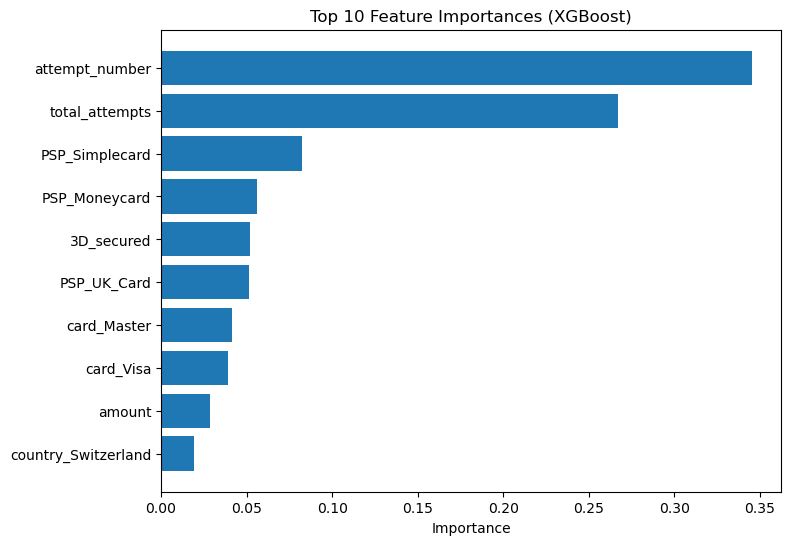

In [7]:
#Erstes Vorhersagemodell mittels XGBoost

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Trainings- und Testdaten laden (hier aus processed-Ordner)
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

# 2. XGBoost-Modell erstellen und trainieren
model = XGBClassifier(random_state=42, eval_metric='logloss')
model.fit(X_train, y_train)

# 3. Vorhersagen für Testdaten erzeugen
y_pred = model.predict(X_test)

# 4. Modellgüte berechnen
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"XGBoost Modell-Ergebnisse auf Testdaten:")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1-Score  : {f1:.3f}")
print("\nKonfusionsmatrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 5. Feature Importance (wichtigste Einflussfaktoren visualisieren)
importances = model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

print("\nWichtigste Einflussfaktoren (Feature Importance):")
print(feature_importance_df.head(10))

#Visualisierung
plt.figure(figsize=(8,6))
plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()


scale_pos_weight = 3.93
XGBoost (mit scale_pos_weight) auf Testdaten:
Accuracy  : 0.678
Precision : 0.359
Recall    : 0.746
F1-Score  : 0.485

Konfusionsmatrix:
 [[5313 2723]
 [ 520 1526]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.66      0.77      8036
           1       0.36      0.75      0.48      2046

    accuracy                           0.68     10082
   macro avg       0.63      0.70      0.63     10082
weighted avg       0.80      0.68      0.71     10082

Gesamtnutzen (Kostensensitive Bewertung): -13649
TP: 1526, FP: 2723, FN: 520, TN: 5313

Wichtigste Einflussfaktoren (Feature Importance):
                feature  importance
2        attempt_number    0.391210
3        total_attempts    0.247654
9        PSP_Simplecard    0.080049
10          PSP_UK_Card    0.049712
8         PSP_Moneycard    0.047328
1            3D_secured    0.041775
4           card_Master    0.038513
5             card_Visa    0.0377

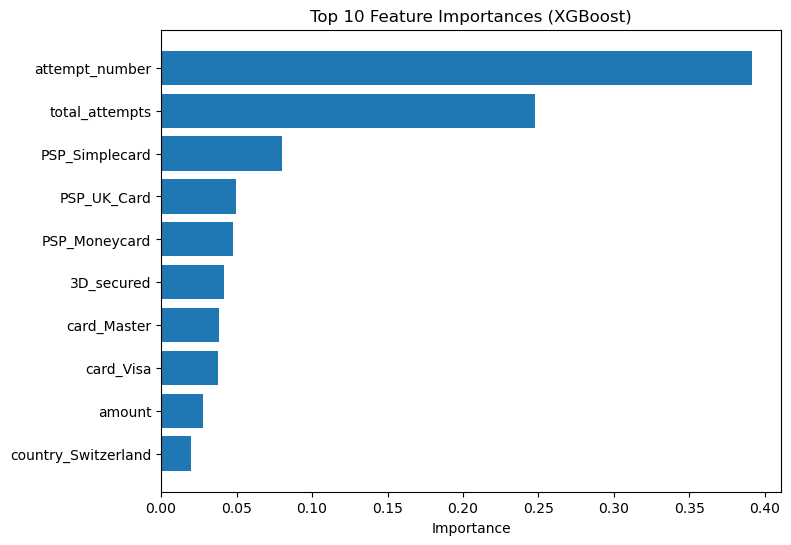

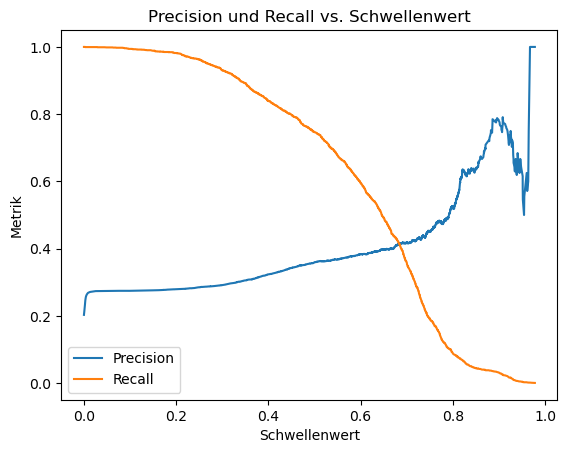

Bester Threshold für maximalen F1-Score: 0.51

Metriken mit optimiertem Threshold:
Accuracy  : 0.685
Precision : 0.363
Recall    : 0.737
F1-Score  : 0.487
Konfusionsmatrix:
 [[5394 2642]
 [ 538 1508]]

Auswertung für Tag-Transaktionen:
Recall: 0.733, Precision: 0.363, F1-Score: 0.485

Auswertung für Nacht-Transaktionen:
Recall: 0.740, Precision: 0.364, F1-Score: 0.488


In [3]:
#2. Variante des Vorhersagemodells
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

# Trainings- und Testdaten laden
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

# 1. Berechne scale_pos_weight
ratio = (len(y_train) - sum(y_train)) / sum(y_train)
print(f"scale_pos_weight = {ratio:.2f}")

# 2. XGBoost mit scale_pos_weight trainieren
model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=ratio)
model.fit(X_train, y_train)

# 3. Vorhersagen & Auswertung
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"XGBoost (mit scale_pos_weight) auf Testdaten:")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1-Score  : {f1:.3f}")
print("\nKonfusionsmatrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Kostensensitive Bewertung
costs = {
    'TP': +1, 'FP': -5, 'FN': -3, 'TN': 0
}
TN, FP, FN, TP = cm.ravel()
total_benefit = (TP * costs['TP'] + FP * costs['FP'] +
                 FN * costs['FN'] + TN * costs['TN'])
print(f"Gesamtnutzen (Kostensensitive Bewertung): {total_benefit}")

# Wahrscheinlichkeiten berechnen
y_proba = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Feature Importance wieder anzeigen
importances = model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

print("\nWichtigste Einflussfaktoren (Feature Importance):")
print(feature_importance_df.head(10))

#Visualisierung
plt.figure(figsize=(8,6))
plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Schwellenwert')
plt.ylabel('Metrik')
plt.legend()
plt.title('Precision und Recall vs. Schwellenwert')
plt.show()

# Besten Threshold bestimmen
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_index = f1_scores.argmax()
best_threshold = thresholds[best_index]
print(f"Bester Threshold für maximalen F1-Score: {best_threshold:.2f}")

# Neue Prediction mit optimalem Threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)
print("\nMetriken mit optimiertem Threshold:")
print(f"Accuracy  : {accuracy_score(y_test, y_pred_opt):.3f}")
print(f"Precision : {precision_score(y_test, y_pred_opt):.3f}")
print(f"Recall    : {recall_score(y_test, y_pred_opt):.3f}")
print(f"F1-Score  : {f1_score(y_test, y_pred_opt):.3f}")
print("Konfusionsmatrix:\n", confusion_matrix(y_test, y_pred_opt))

# Beispiel Tages- und Nachtauswertung
df_test = df.loc[X_test.index]
df_test['hour'] = pd.to_datetime(df_test['tmsp']).dt.hour

mask_day = df_test['hour'].between(8, 18)
mask_night = ~mask_day

for label, mask in zip(['Tag', 'Nacht'], [mask_day, mask_night]):
    print(f"\nAuswertung für {label}-Transaktionen:")
    print(f"Recall: {recall_score(y_test[mask], y_pred_opt[mask]):.3f}, "
          f"Precision: {precision_score(y_test[mask], y_pred_opt[mask]):.3f}, "
          f"F1-Score: {f1_score(y_test[mask], y_pred_opt[mask]):.3f}")
